# Exercise 4.2

First of all, we import usefull libraries.

In [1]:
import math
import numpy as np
import pydot
import copy
from IPython.display import Image

We load stored data.

In [2]:
%store -r data_set
%store -r labels

In C4.5 method we generate a non-binary tree. We use code from class.

In [3]:
class Leaf:

    def __init__(self, elements, labels, ids):
        self.child_leafs = []
        self.elements = elements
        self.labels = labels
        self.completed = False
        self.ids = ids

    def get_elements(self):
        return self.elements

    def set_child_leafs(self, new_leafs):
        self.child_leafs = new_leafs

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def get_child_leafs(self):
        return self.child_leafs

    def get_ids(self):
        return self.ids

ids = list(range(len(data_set)))
root = Leaf(data_set, labels, ids)
current_node = root

def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()

def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique

def is_leaf_completed(node):
    if node.is_completed():
        child_nodes = node.get_child_leafs()
        if len(child_nodes) == 0:
            return None
        is_child_to_return = False
        for i in range(len(child_nodes)):
            if not child_nodes[i].is_completed():
                return child_nodes[i]
            else:
                new_node = is_leaf_completed(child_nodes[i])
                if new_node != None:
                    is_child_to_return=True
        if is_child_to_return:
            return new_node
    return node

def find_leaf_not_completed(root_node):
    return is_leaf_completed(root_node)

def get_current_node(root):
    return find_leaf_not_completed(root)

def calculate_entropy(labels):
    unique_labels, labels_count = np.unique(labels, return_counts=True)
    entropy = 0
    size = len(labels)
    for i in range(len(unique_labels)):
        if labels_count[i] > 0:
            log2 = math.log((labels_count[i] * 1.0) / (size * 1.0), 2)
        else:
            log2 = 0.0
        entropy = entropy - 1.0 * ((labels_count[i] * 1.0) / size) * log2
    return entropy

def calculate_split_candidate_entropy(full_entropy, labels, elements, unique_labels, unique_elements, iter):
    split_entropy = 0
    for i in range(len(unique_elements)):
        indices = np.where(np.array(elements)[..., iter].tolist() == unique_elements[i])
        unique_size = len(indices[0].tolist())
        filtered_labels = np.array(labels)[indices]
        for j in range(len(unique_labels)):
            labels_count = filtered_labels.tolist().count(unique_labels[j])
            if labels_count > 0:
                log2 = math.log((labels_count * 1.0) / (unique_size * 1.0), 2)
            else:
                log2 = 0.0
            split_entropy = split_entropy - 1.0 * (
                    (labels_count * 1.0) / unique_size * 1.0) * log2 * unique_size * 1.0 / len(elements) * 1.0
    return (full_entropy - split_entropy)

def split(current_node, split_values, column_id, split_history):
    new_leafs = []
    for i in range(len(split_values)):
        indices = np.where(np.array(current_node.get_elements())[..., column_id].tolist() == split_values[i])
        new_leaf_elements = np.array(current_node.get_elements())[indices].tolist()
        new_leaf_labels   = np.array(current_node.get_labels())[indices].tolist()
        new_leaf_ids = np.array(current_node.get_ids())[indices].tolist()
        new_leaf = Leaf(new_leaf_elements,new_leaf_labels, new_leaf_ids)
        split_history.append([str(current_node.ids), str(new_leaf_ids)])
        if len(np.unique(new_leaf_labels)) == 1:
            new_leaf.set_completed()
        new_leafs.append(new_leaf)
    current_node.set_child_leafs(new_leafs)
    current_node.set_completed()
    return current_node, split_history

def build(root):
    stop_criterion = False
    split_history = []
    current_node = root
    unique_labels = get_unique_labels(root.get_labels())
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        full_entropy = calculate_entropy(current_node.get_labels())
        max_entropy_id = 0
        max_entropy_value = 0
        for i in range(len(unique_values)):
            split_entropy = calculate_split_candidate_entropy(full_entropy,
                                                                      current_node.get_labels(),
                                                                      current_node.get_elements(),
                                                                      unique_labels,
                                                                      unique_values[i], i)
            if split_entropy > max_entropy_value:
                max_entropy_id = i
                max_entropy_value = split_entropy
        current_node, split_history = split(current_node, unique_values[max_entropy_id], max_entropy_id, split_history)
        new_node = get_current_node(root)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root, split_history

Now we fill the code with pydot, so we plot results of $C4.5$ method. We see that we obtain different groups than with CART method (this one uses entropy, information gain).

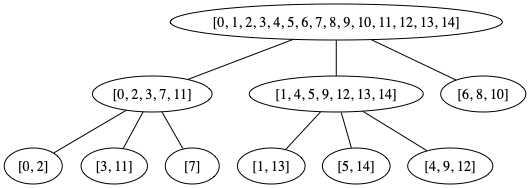

In [4]:
c45_tree, split_history_c45 = build(root)

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('c45_tree.png', format='png')
    
plot_tree(split_history_c45)

Image(filename='c45_tree.png')